<a href="https://colab.research.google.com/github/vishoTheEver/ethinicity-recognition-UTKfaces/blob/main/utk_ml_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task #1: Baseline

In [ ]:
# imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report
import torchvision
import numpy as np
import tqdm
import os

In [ ]:
unique_labels = ['White', 'Black', 'Asian', 'Indian']

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = models.resnet18(weights=None)
    num_features = self.resnet.fc.in_features
    self.resnet.fc = nn.Linear(num_features, len(unique_labels))

  def forward(self, x):
    return self.resnet(x)

In [ ]:
net = ResNet()
lr = 0.001
nb_epochs = 30
batch_size = 32
seed = 777
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

In [ ]:
!unzip data.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/utk_race_cc1_seed777/val/0/4_1_0_20170109193813519.jpg.chip.jpg  
  inflating: ./data/__MACOSX/utk_race_cc1_seed777/val/0/._4_1_0_20170109193813519.jpg.chip.jpg  
  inflating: ./data/utk_race_cc1_seed777/val/0/10_0_0_20170110225502403.jpg.chip.jpg  
  inflating: ./data/__MACOSX/utk_race_cc1_seed777/val/0/._10_0_0_20170110225502403.jpg.chip.jpg  
  inflating: ./data/utk_race_cc1_seed777/val/0/26_0_0_20170117171702618.jpg.chip.jpg  
  inflating: ./data/__MACOSX/utk_race_cc1_seed777/val/0/._26_0_0_20170117171702618.jpg.chip.jpg  
  inflating: ./data/utk_race_cc1_seed777/val/0/6_1_0_20170109205251485.jpg.chip.jpg  
  inflating: ./data/__MACOSX/utk_race_cc1_seed777/val/0/._6_1_0_20170109205251485.jpg.chip.jpg  
  inflating: ./data/utk_race_cc1_seed777/val/0/28_0_0_20170116192500842.jpg.chip.jpg  
  inflating: ./data/__MACOSX/utk_race_cc1_seed777/val/0/._28_0_0_20170116192500842.jpg.chip.jpg  
  inflating: ./data/utk_race

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.RandomCrop(104),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])
test_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.CenterCrop(104),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

# Load the dataset and apply transformations
train_dataset = ImageFolder('data/utk_race_cc1_seed{}/train/'.format(seed), transform=train_transform)
val_dataset = ImageFolder('data/utk_race_cc1_seed{}/val/'.format(seed), transform=test_transform)
test_dataset = ImageFolder('data/utk_race_cc1_seed{}/test/'.format(seed), transform=test_transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# inverse normalization
inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean = [0., 0. ,0.],
        std = [1/0.5, 1/0.5, 1/0.5]
    ),
    transforms.Normalize(
        mean = [-0.5, -0.5, -0.5],
        std = [1., 1., 1.]
    )
])

Label = Indian


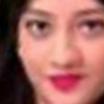

In [ ]:
i = np.random.choice(len(train_dataset))
input_tensor = inv_normalize(train_dataset[i][0])
grid = torchvision.utils.make_grid(input_tensor, nrow=1)
print("Label =", unique_labels[train_dataset[i][1]])
transforms.ToPILImage()(grid)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cude":
  net = net.cuda()

In [ ]:
print(net)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
print("model in training...")

net.train()
for epoch in range(1, nb_epochs+1):
  train_loss = []
  val_loss = []
  patience = 0
  best_val_loss = 999

  for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()

    loss = loss_fn(net(x), y)
    loss.backward()

    optimizer.step()

    train_loss.append(loss.item())

  net.eval()

  for x, y in val_dataloader:
    x, y = x.to(device), y.to(device)

    loss = loss_fn(net(x), y)

    val_loss.append(loss.item())

  print("epoch: {}/{}, train loss: {:.3f} | val loss: {:3f}".format(epoch, nb_epochs, np.mean(train_loss), np.mean(val_loss)))

  if best_val_loss - np.mean(val_loss) > 0.01:
    best_val_loss = np.mean(val_loss)
    patience = 0

    if not os.path.exists('./outputs'):
      os.makedirs('./outputs')
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,

        },
        './outputs/best_model.pth'
    )
    print("val_loss improved. Saved best model")

model in training...
epoch: 1/30, train loss: 0.987 | val loss: 0.785277
val_loss improved. Saved best model


KeyboardInterrupt: 

In [ ]:
net = ResNet()
net.load_state_dict(torch.load('./outputs/best_model.pth')['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
  net = net.cuda()
print('loaded best model')

In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in test_dataloader:
  x, y = x.to(device), y.to(device)
  y_pred = net(x)

  ys.append(y.detach().cpu().data.numpy())
  y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
print(classification_report(ys,y_preds))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       980
           1       0.75      0.73      0.74       485
           2       0.52      0.79      0.63       324
           3       0.82      0.28      0.42       412

    accuracy                           0.70      2201
   macro avg       0.71      0.66      0.64      2201
weighted avg       0.72      0.70      0.68      2201



# Task #2: Relationship between Learning Rate and Performance

Objective: We will be conducting three experiments with different learning rates (0.001, 0.01, 0.1) while keeping the batch size constant at 32.

Learning rate: 0.1, 0.001, 0.0001
Epochs: 30
Batch size: 32 (default)

In [ ]:
def train_and_evaluate(net, train_dataloader, val_dataloader, test_dataloader, learning_rate, nb_epochs=30):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    for epoch in range(nb_epochs):
        net.train()
        train_loss = 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_loss_history.append(train_loss)

        net.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                loss = loss_fn(net(x), y)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_loss_history.append(val_loss)

    return train_loss_history, val_loss_history


In [ ]:
import matplotlib.pyplot as plt

learning_rates = [0.001, 0.01, 0.1]
epochs = range(1, 31)

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    net = ResNet()
    train_loss, val_loss = train_and_evaluate(net, train_dataloader, val_dataloader, test_dataloader, learning_rate=lr, nb_epochs=30)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, train_loss, label=f'Training Loss (LR={lr})')
    plt.plot(epochs, val_loss, label=f'Validation Loss (LR={lr})', linestyle='--')

    plt.title(f'Training and Validation Loss by (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Training with learning rate: 0.001


### Learning rate 0.001
For the learning rate of 0.001, we can see that both the training and validation loss decrease steadily over the epochs. This suggests that the learning rate is likely well-suited for the model and dataset, as it allows the model to learn gradually without overshooting the minimum of the loss function.

### Learning rate 0.01
With a learning rate of 0.01, the training loss decreases at a faster rate initially compared to 0.001, but the validation loss starts to plateau and even slightly increase towards the end. This could be an indication that the model is beginning to overfit the training data or that the learning rate is slightly too high and the model is not stabilizing well on the validation set.

### Learning rate 0.1
When the learning rate is increased to 0.1, both training and validation losses exhibit higher variability and the losses are overall higher compared to the other two learning rates. This high learning rate is likely causing the model's parameters to update too aggressively, leading to instability in learning and an inability to converge to the minimum of the loss function effectively.

### Conclusion
The effects observed can be explained by the role the learning rate plays in the optimization process. A learning rate that's too low leads to slow convergence, while a rate that's too high can overshoot the optimal point or fail to converge. From the plot, it appears that a learning rate of 0.001 provides a good balance for steady convergence without overshooting. The learning rate of 0.01 seems to be on the verge of being too high, as indicated by the plateau in validation loss, suggesting the model might not be generalizing as well. The learning rate of 0.1 is clearly too high, causing high variability in the loss, indicating that the model parameters are likely oscillating and not settling down to a good set of weights.


#### Terms Used
Convergence: The process where the algorithm iteratively reduces the error, approaching a minimum in the loss function.

Overshooting: When the learning rate is too high, a condition that causes the algorithm to bypass the minimum and potentially diverge, failing to find the optimal solution.

# Task #3: Relationship between Batch Size and Performance

In [ ]:
import matplotlib.pyplot as plt

# Example usage with plotting
batch_sizes = [4, 64, 128]
epochs = range(1, 31)  # Assuming 30 epochs

plt.figure(figsize=(12, 8))

for batch_size in batch_sizes:
    # Create the DataLoaders with the current batch size
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Training with batch size: {batch_size}")
    net = ResNet()
    train_loss, val_loss = train_and_evaluate(net, train_dataloader, val_dataloader, test_dataloader, learning_rate=0.001, nb_epochs=30)

    # Plotting
    plt.plot(epochs, train_loss, label=f'Training Loss (Batch Size={batch_size})')
    plt.plot(epochs, val_loss, label=f'Validation Loss (Batch Size={batch_size})', linestyle='--')

plt.title('Training and Validation Loss by Batch Size')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Task #4: Best Model